In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import torch
from torchvision import transforms

In [29]:
csv_file = '/home/jovyan/work/hw_dataset/butterflies and moths.csv'
train_dir = '/home/jovyan/work/hw_dataset'
valid_dir = '/home/jovyan/work/hw_dataset'
test_dir = '/home/jovyan/work/hw_dataset'

In [30]:
df = pd.read_csv(csv_file)
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [31]:
num_classes = df['labels'].nunique()
print(f"Количество классов: {num_classes}")
print(f"Количество изображений в датасете: {len(df)}")

Количество классов: 100
Количество изображений в датасете: 13594


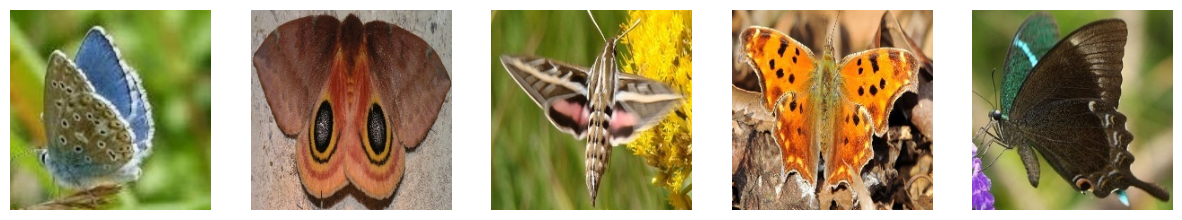

In [32]:
def show_images(image_paths, base_dir, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, img_path in enumerate(np.random.choice(image_paths, n, replace=False)):
        img = Image.open(os.path.join(base_dir, img_path))
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

train_image_paths = df[df['data set'] == 'train']['filepaths'].values
show_images(train_image_paths, train_dir)

## Распределение классов

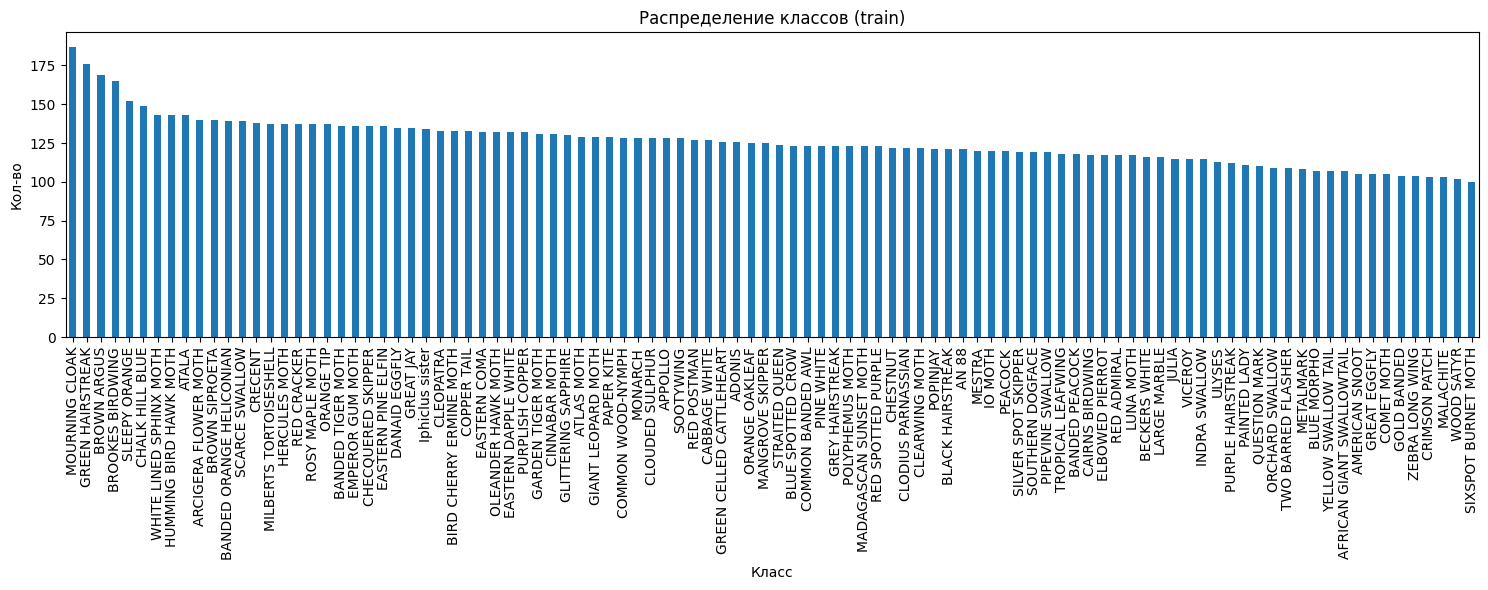

In [ ]:
class_counts = df[df['data set'] == 'train']['labels'].value_counts()
plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar')
plt.title('Распределение классов (train)')
plt.xlabel('Класс')
plt.ylabel('Кол-во')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Некоторые классы имеют гораздо больше изображений, чем другие. Это может привести к тому, что модель будет склонна к предсказанию доминирующих классов и хуже обучаться на менее представленных классах. В частности, такие классы, как MOURNING CLOAK, имеют значительно больше изображений по сравнению с классами, такими как SIXSPOT BURNET MOTH, что делает последние уязвимыми к ошибкам в предсказаниях.
В качестве решения этой проблемы можно попробовать применить взвешенную функцию потерь или использовать oversampling/undersampling для увеличения/уменьшения выборки редких/доминирующих классов. Также можно поэкспериментировать с аугментацией редких классов, для увеличения их кол-ва и вариативности.



## Усреднённые фото по случайным классам

In [ ]:
def get_average_image(image_paths, base_dir):
    avg_image = np.zeros_like(np.array(Image.open(os.path.join(base_dir, image_paths[0]))), dtype=np.float32)

    for img_path in image_paths:
        img = np.array(Image.open(os.path.join(base_dir, img_path)))
        avg_image += img.astype(np.float32)

    avg_image /= len(image_paths)

    return avg_image.astype(np.uint8)

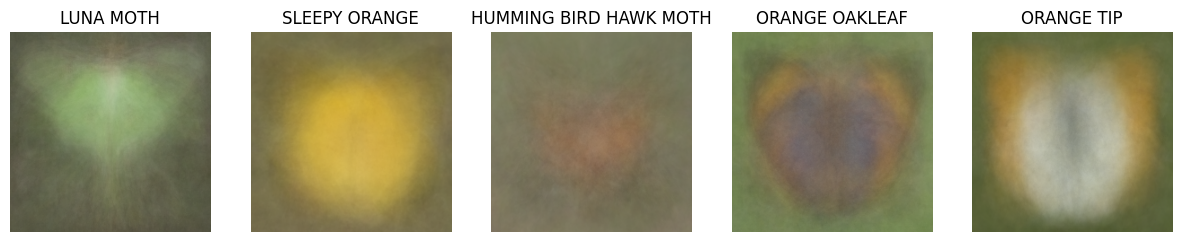

In [ ]:
class_labels = df['labels'].unique()
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, label in enumerate(np.random.choice(class_labels, 5, replace=False)):
    class_image_paths = df[df['labels'] == label]['filepaths'].values
    avg_image = get_average_image(class_image_paths, train_dir)

    axes[i].imshow(avg_image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

Из фото выше можно увидеть, что основные черты классов бабочек заключаются в центре изображения, а фон часто остаётся однородным и размытым. Это может указывать на то, что модель может переобучиться на фоновый контекст, игнорируя важные детали бабочек. Кроме того, у некоторых классов видны сходные цветовые пятна и текстуры, что может привести к сложности в различении между похожими классами.
Для борьбы с этим, в третьей части проведём эксперимент, добавив аугментации, изменяющие фон и делая фокус на основных признаках бабочек. Это поможет модели лучше учиться на значимых чертах объектов, игнорируя фоновый шум.

## Экспериментальная. Часть 1

In [12]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 4.0 MB/s eta 0:00:00a 0:00:01


In [14]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 947.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.0 MB/s eta 0:00:00a 0:00:01


In [58]:
import os
import torch
import torch.nn as nn
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassAUROC
from torchvision import models, transforms
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import timm

In [16]:
class ButterflyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [33]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ButterflyDataset(df[df['data set'] == 'train'], train_dir, transform=train_transform)
val_dataset = ButterflyDataset(df[df['data set'] == 'valid'], valid_dir, transform=val_test_transform)
test_dataset = ButterflyDataset(df[df['data set'] == 'test'], test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
def freeze_model_layers(model):
    for param in model.parameters():
        param.requires_grad = False

In [20]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|████████████████████████████████████████████████████████████████████████████████| 171M/171M [00:06<00:00, 26.4MB/s]


In [21]:
efficientnet = models.efficientnet_b0(pretrained=True)
freeze_model_layers(efficientnet)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 100)
efficientnet = efficientnet.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 26.1MB/s]


In [22]:
densenet = models.densenet121(pretrained=True)
freeze_model_layers(densenet)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 100)
densenet = densenet.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:00<00:00, 36.3MB/s]


In [23]:
vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=100)
freeze_model_layers(vit)
vit.head = nn.Linear(vit.head.in_features, 100)
vit = vit.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [24]:
swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=100)
freeze_model_layers(swin)
swin.head = nn.Linear(swin.head.in_features, 100)
swin = swin.to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [25]:
def train_model(model, model_name, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
    f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
    auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        accuracy_metric.reset()
        f1_metric.reset()
        auroc_metric.reset()

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)

                accuracy_metric.update(preds, labels)
                f1_metric.update(preds, labels)
                auroc_metric.update(outputs.softmax(dim=-1), labels)

                train_acc = accuracy_metric.compute()
                train_f1 = f1_metric.compute()
                train_auroc = auroc_metric.compute()

                tepoch.set_postfix(loss=running_loss / len(train_loader), accuracy=train_acc.item(), f1=train_f1.item(), roc_auc=train_auroc.item())

        model.eval()
        val_accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
        val_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
        val_auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)

                val_accuracy_metric.update(preds, labels)
                val_f1_metric.update(preds, labels)
                val_auroc_metric.update(outputs.softmax(dim=-1), labels)

        val_acc = val_accuracy_metric.compute()
        val_f1 = val_f1_metric.compute()
        val_auroc = val_auroc_metric.compute()

        print(f"Validation - Epoch {epoch+1}: Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, ROC AUC: {val_auroc:.4f}")

In [26]:
def evaluate_on_test_set(model, test_loader, model_name, results_df):
    test_accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
    test_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
    test_auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            test_accuracy_metric.update(preds, labels)
            test_f1_metric.update(preds, labels)
            test_auroc_metric.update(outputs.softmax(dim=-1), labels)

    test_acc = test_accuracy_metric.compute().item()
    test_f1 = test_f1_metric.compute().item()
    test_auroc = test_auroc_metric.compute().item()

    print(f"Test Results for {model_name}: Accuracy: {test_acc:.4f}, F1-Score: {test_f1:.4f}, ROC AUC: {test_auroc:.4f}")

    new_results = pd.DataFrame({
        'Model': [model_name],
        'Test_Accuracy': [test_acc],
        'Test_F1_Score': [test_f1],
        'Test_ROC_AUC': [test_auroc]
    })

    results_df = pd.concat([results_df, new_results], ignore_index=True)
    
    return results_df

In [27]:
results_df = pd.DataFrame(columns=['Model', 'Test_Accuracy', 'Test_F1_Score', 'Test_ROC_AUC'])

# Обучение 3 CNN и 2 трансформеров

In [34]:
train_model(resnet101, 'ResNet101', train_loader, val_loader, num_epochs=10)

Epoch 1/10:   0%|                                                                            | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/10: 100%|██████████████| 394/394 [07:27<00:00,  1.14s/batch, accuracy=0.646, f1=0.651, loss=1.71, roc_auc=0.967]


Validation - Epoch 1: Accuracy: 0.8380, F1-Score: 0.8313, ROC AUC: 0.9978


Epoch 2/10: 100%|██████████████| 394/394 [04:24<00:00,  1.49batch/s, accuracy=0.849, f1=0.85, loss=0.599, roc_auc=0.997]


Validation - Epoch 2: Accuracy: 0.8400, F1-Score: 0.8339, ROC AUC: 0.9981


Epoch 3/10: 100%|█████████████| 394/394 [03:14<00:00,  2.02batch/s, accuracy=0.878, f1=0.879, loss=0.457, roc_auc=0.998]


Validation - Epoch 3: Accuracy: 0.8740, F1-Score: 0.8617, ROC AUC: 0.9985


Epoch 4/10: 100%|██████████████| 394/394 [02:58<00:00,  2.21batch/s, accuracy=0.889, f1=0.89, loss=0.392, roc_auc=0.999]


Validation - Epoch 4: Accuracy: 0.8740, F1-Score: 0.8658, ROC AUC: 0.9986


Epoch 5/10: 100%|█████████████| 394/394 [02:52<00:00,  2.28batch/s, accuracy=0.898, f1=0.899, loss=0.346, roc_auc=0.999]


Validation - Epoch 5: Accuracy: 0.8860, F1-Score: 0.8832, ROC AUC: 0.9985


Epoch 6/10: 100%|█████████████| 394/394 [02:52<00:00,  2.28batch/s, accuracy=0.911, f1=0.911, loss=0.304, roc_auc=0.999]


Validation - Epoch 6: Accuracy: 0.8800, F1-Score: 0.8735, ROC AUC: 0.9986


Epoch 7/10: 100%|███████████████| 394/394 [02:51<00:00,  2.30batch/s, accuracy=0.91, f1=0.91, loss=0.288, roc_auc=0.999]


Validation - Epoch 7: Accuracy: 0.8840, F1-Score: 0.8780, ROC AUC: 0.9984


Epoch 8/10: 100%|█████████████| 394/394 [02:52<00:00,  2.29batch/s, accuracy=0.922, f1=0.923, loss=0.259, roc_auc=0.999]


Validation - Epoch 8: Accuracy: 0.8960, F1-Score: 0.8948, ROC AUC: 0.9985


Epoch 9/10: 100%|█████████████| 394/394 [02:53<00:00,  2.27batch/s, accuracy=0.923, f1=0.923, loss=0.248, roc_auc=0.999]


Validation - Epoch 9: Accuracy: 0.8820, F1-Score: 0.8767, ROC AUC: 0.9981


Epoch 10/10: 100%|████████████| 394/394 [02:52<00:00,  2.28batch/s, accuracy=0.925, f1=0.925, loss=0.237, roc_auc=0.999]


Validation - Epoch 10: Accuracy: 0.8940, F1-Score: 0.8882, ROC AUC: 0.9977


In [35]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101', results_df)
print(results_df)

Test Results for ResNet101: Accuracy: 0.8880, F1-Score: 0.8833, ROC AUC: 0.9989
       Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0  ResNet101          0.888       0.883334      0.998905


/tmp/ipykernel_2200/4221049418.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_results], ignore_index=True)


In [36]:
train_model(efficientnet, 'EfficientNet-B0', train_loader, val_loader, num_epochs=5)

Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/5: 100%|█████████████████| 394/394 [02:19<00:00,  2.81batch/s, accuracy=0.67, f1=0.676, loss=1.97, roc_auc=0.97]


Validation - Epoch 1: Accuracy: 0.8500, F1-Score: 0.8429, ROC AUC: 0.9955


Epoch 2/5: 100%|██████████████| 394/394 [02:20<00:00,  2.81batch/s, accuracy=0.853, f1=0.854, loss=0.763, roc_auc=0.997]


Validation - Epoch 2: Accuracy: 0.8800, F1-Score: 0.8770, ROC AUC: 0.9960


Epoch 3/5: 100%|██████████████| 394/394 [02:21<00:00,  2.79batch/s, accuracy=0.879, f1=0.879, loss=0.564, roc_auc=0.998]


Validation - Epoch 3: Accuracy: 0.9020, F1-Score: 0.8995, ROC AUC: 0.9967


Epoch 4/5: 100%|██████████████| 394/394 [02:24<00:00,  2.73batch/s, accuracy=0.897, f1=0.898, loss=0.464, roc_auc=0.998]


Validation - Epoch 4: Accuracy: 0.9040, F1-Score: 0.8994, ROC AUC: 0.9973


Epoch 5/5: 100%|████████████████| 394/394 [02:24<00:00,  2.73batch/s, accuracy=0.91, f1=0.91, loss=0.405, roc_auc=0.999]


Validation - Epoch 5: Accuracy: 0.9220, F1-Score: 0.9189, ROC AUC: 0.9975


In [37]:
results_df = evaluate_on_test_set(efficientnet, test_loader, 'EfficientNet-B0', results_df)
print(results_df)

Test Results for EfficientNet-B0: Accuracy: 0.9060, F1-Score: 0.9017, ROC AUC: 0.9987
             Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0        ResNet101          0.888       0.883334      0.998905
1  EfficientNet-B0          0.906       0.901651      0.998667


In [39]:
train_model(densenet, 'DenseNet121', train_loader, val_loader, num_epochs=5)

Epoch 1/5: 100%|██████████████| 394/394 [02:06<00:00,  3.11batch/s, accuracy=0.929, f1=0.929, loss=0.283, roc_auc=0.999]


Validation - Epoch 1: Accuracy: 0.9040, F1-Score: 0.9001, ROC AUC: 0.9990


Epoch 2/5: 100%|██████████████████| 394/394 [02:05<00:00,  3.14batch/s, accuracy=0.941, f1=0.941, loss=0.238, roc_auc=1]


Validation - Epoch 2: Accuracy: 0.9220, F1-Score: 0.9207, ROC AUC: 0.9986


Epoch 3/5: 100%|██████████████████| 394/394 [02:03<00:00,  3.20batch/s, accuracy=0.946, f1=0.947, loss=0.206, roc_auc=1]


Validation - Epoch 3: Accuracy: 0.9000, F1-Score: 0.8976, ROC AUC: 0.9986


Epoch 4/5: 100%|██████████████████| 394/394 [02:04<00:00,  3.17batch/s, accuracy=0.952, f1=0.953, loss=0.185, roc_auc=1]


Validation - Epoch 4: Accuracy: 0.9060, F1-Score: 0.9029, ROC AUC: 0.9988


Epoch 5/5: 100%|██████████████████| 394/394 [02:04<00:00,  3.17batch/s, accuracy=0.954, f1=0.954, loss=0.169, roc_auc=1]


Validation - Epoch 5: Accuracy: 0.9260, F1-Score: 0.9244, ROC AUC: 0.9983


In [40]:
results_df = evaluate_on_test_set(densenet, test_loader, 'DenseNet121', results_df)
print(results_df)

Test Results for DenseNet121: Accuracy: 0.9360, F1-Score: 0.9321, ROC AUC: 0.9996
             Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0        ResNet101          0.888       0.883334      0.998905
1  EfficientNet-B0          0.906       0.901651      0.998667
2      DenseNet121          0.936       0.932095      0.999604


In [41]:
train_model(vit, 'ViT', train_loader, val_loader, num_epochs=5)

Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/5: 100%|████████████████| 394/394 [04:44<00:00,  1.39batch/s, accuracy=0.797, f1=0.8, loss=0.961, roc_auc=0.991]


Validation - Epoch 1: Accuracy: 0.9180, F1-Score: 0.9147, ROC AUC: 0.9989


Epoch 2/5: 100%|██████████████| 394/394 [04:49<00:00,  1.36batch/s, accuracy=0.932, f1=0.933, loss=0.282, roc_auc=0.999]


Validation - Epoch 2: Accuracy: 0.9400, F1-Score: 0.9386, ROC AUC: 0.9995


Epoch 3/5: 100%|██████████████████| 394/394 [04:58<00:00,  1.32batch/s, accuracy=0.948, f1=0.949, loss=0.202, roc_auc=1]


Validation - Epoch 3: Accuracy: 0.9500, F1-Score: 0.9474, ROC AUC: 0.9994


Epoch 4/5: 100%|██████████████████| 394/394 [04:59<00:00,  1.32batch/s, accuracy=0.958, f1=0.958, loss=0.158, roc_auc=1]


Validation - Epoch 4: Accuracy: 0.9520, F1-Score: 0.9497, ROC AUC: 0.9996


Epoch 5/5: 100%|██████████████████| 394/394 [04:48<00:00,  1.37batch/s, accuracy=0.963, f1=0.963, loss=0.134, roc_auc=1]


Validation - Epoch 5: Accuracy: 0.9520, F1-Score: 0.9502, ROC AUC: 0.9995


In [42]:
results_df = evaluate_on_test_set(vit, test_loader, 'ViT', results_df)
print(results_df)

Test Results for ViT: Accuracy: 0.9580, F1-Score: 0.9562, ROC AUC: 0.9996
             Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0        ResNet101          0.888       0.883334      0.998905
1  EfficientNet-B0          0.906       0.901651      0.998667
2      DenseNet121          0.936       0.932095      0.999604
3              ViT          0.958       0.956193      0.999552


In [44]:
train_model(swin, 'Swin Transformer', train_loader, val_loader, num_epochs=5)

Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/5: 100%|██████████████████| 394/394 [03:06<00:00,  2.11batch/s, accuracy=0.954, f1=0.955, loss=0.164, roc_auc=1]


Validation - Epoch 1: Accuracy: 0.9100, F1-Score: 0.9094, ROC AUC: 0.9982


Epoch 2/5: 100%|██████████████████| 394/394 [02:06<00:00,  3.12batch/s, accuracy=0.959, f1=0.959, loss=0.145, roc_auc=1]


Validation - Epoch 2: Accuracy: 0.9120, F1-Score: 0.9072, ROC AUC: 0.9982


Epoch 3/5: 100%|██████████████████| 394/394 [02:05<00:00,  3.13batch/s, accuracy=0.961, f1=0.961, loss=0.142, roc_auc=1]


Validation - Epoch 3: Accuracy: 0.9140, F1-Score: 0.9112, ROC AUC: 0.9983


Epoch 4/5: 100%|██████████████████| 394/394 [02:02<00:00,  3.20batch/s, accuracy=0.965, f1=0.965, loss=0.126, roc_auc=1]


Validation - Epoch 4: Accuracy: 0.9220, F1-Score: 0.9154, ROC AUC: 0.9982


Epoch 5/5: 100%|██████████████████| 394/394 [02:06<00:00,  3.12batch/s, accuracy=0.967, f1=0.967, loss=0.116, roc_auc=1]


Validation - Epoch 5: Accuracy: 0.9240, F1-Score: 0.9210, ROC AUC: 0.9984


In [45]:
results_df = evaluate_on_test_set(swin, test_loader, 'Swin Transformer', results_df)
print(results_df)

Test Results for Swin Transformer: Accuracy: 0.9280, F1-Score: 0.9275, ROC AUC: 0.9995
              Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0         ResNet101          0.888       0.883334      0.998905
1   EfficientNet-B0          0.906       0.901651      0.998667
2       DenseNet121          0.936       0.932095      0.999604
3               ViT          0.958       0.956193      0.999552
4  Swin Transformer          0.928       0.927454      0.999523


# Экспериментальная. Часть 2

In [50]:
from torch.optim.lr_scheduler import StepLR

In [51]:
def train_resnet101_experiment(optimizer_name, optimizer, lr, scheduler_step, scheduler_gamma, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(resnet101.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
    f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
    auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

    for epoch in range(num_epochs):
        resnet101.train()
        running_loss = 0.0
        accuracy_metric.reset()
        f1_metric.reset()
        auroc_metric.reset()

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = resnet101(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)

                accuracy_metric.update(preds, labels)
                f1_metric.update(preds, labels)
                auroc_metric.update(outputs.softmax(dim=-1), labels)

                train_acc = accuracy_metric.compute()
                train_f1 = f1_metric.compute()
                train_auroc = auroc_metric.compute()

                tepoch.set_postfix(loss=running_loss / len(train_loader), accuracy=train_acc.item(), f1=train_f1.item(), roc_auc=train_auroc.item())

        scheduler.step()

        resnet101.eval()
        val_accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=100).to(device)
        val_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=100, average='weighted').to(device)
        val_auroc_metric = torchmetrics.classification.MulticlassAUROC(num_classes=100).to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet101(inputs)
                preds = torch.argmax(outputs, dim=1)

                val_accuracy_metric.update(preds, labels)
                val_f1_metric.update(preds, labels)
                val_auroc_metric.update(outputs.softmax(dim=-1), labels)

        val_acc = val_accuracy_metric.compute()
        val_f1 = val_f1_metric.compute()
        val_auroc = val_auroc_metric.compute()

        print(f"Validation - Epoch {epoch+1}: Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, ROC AUC: {val_auroc:.4f}")

In [53]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

Epoch 1/5: 100%|██████████████| 394/394 [02:29<00:00,  2.64batch/s, accuracy=0.926, f1=0.927, loss=0.235, roc_auc=0.999]


Validation - Epoch 1: Accuracy: 0.8760, F1-Score: 0.8726, ROC AUC: 0.9977


Epoch 2/5: 100%|█████████████████████| 394/394 [02:24<00:00,  2.73batch/s, accuracy=0.93, f1=0.93, loss=0.22, roc_auc=1]


Validation - Epoch 2: Accuracy: 0.8640, F1-Score: 0.8572, ROC AUC: 0.9979


Epoch 3/5: 100%|██████████████████| 394/394 [02:23<00:00,  2.75batch/s, accuracy=0.934, f1=0.934, loss=0.207, roc_auc=1]


Validation - Epoch 3: Accuracy: 0.8980, F1-Score: 0.8913, ROC AUC: 0.9978


Epoch 4/5: 100%|████████████████████| 394/394 [02:29<00:00,  2.64batch/s, accuracy=0.936, f1=0.936, loss=0.2, roc_auc=1]


Validation - Epoch 4: Accuracy: 0.8840, F1-Score: 0.8811, ROC AUC: 0.9981


Epoch 5/5: 100%|███████████████████| 394/394 [02:39<00:00,  2.46batch/s, accuracy=0.939, f1=0.939, loss=0.19, roc_auc=1]


Validation - Epoch 5: Accuracy: 0.9040, F1-Score: 0.9011, ROC AUC: 0.9981


In [54]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_Adam_0.001', results_df)
print(results_df)

Test Results for ResNet101_Adam_0.001: Accuracy: 0.9000, F1-Score: 0.8966, ROC AUC: 0.9987
                  Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0             ResNet101          0.888       0.883334      0.998905
1       EfficientNet-B0          0.906       0.901651      0.998667
2           DenseNet121          0.936       0.932095      0.999604
3                   ViT          0.958       0.956193      0.999552
4      Swin Transformer          0.928       0.927454      0.999523
5  ResNet101_Adam_0.001          0.900       0.896597      0.998663


In [55]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.01, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B02

Validation - Epoch 1: Accuracy: 0.6700, F1-Score: 0.6579, ROC AUC: 0.9955


Epoch 2/5: 100%|███████████████| 394/394 [03:00<00:00,  2.18batch/s, accuracy=0.733, f1=0.734, loss=2.17, roc_auc=0.988]


Validation - Epoch 2: Accuracy: 0.7520, F1-Score: 0.7358, ROC AUC: 0.9939


Epoch 3/5: 100%|███████████████| 394/394 [03:08<00:00,  2.09batch/s, accuracy=0.765, f1=0.766, loss=2.15, roc_auc=0.992]


Validation - Epoch 3: Accuracy: 0.7440, F1-Score: 0.7279, ROC AUC: 0.9956


Epoch 4/5: 100%|███████████████| 394/394 [03:06<00:00,  2.12batch/s, accuracy=0.808, f1=0.809, loss=1.89, roc_auc=0.995]


Validation - Epoch 4: Accuracy: 0.8000, F1-Score: 0.7894, ROC AUC: 0.9965


Epoch 5/5: 100%|███████████████| 394/394 [03:08<00:00,  2.09batch/s, accuracy=0.825, f1=0.827, loss=1.79, roc_auc=0.996]


Validation - Epoch 5: Accuracy: 0.7920, F1-Score: 0.7795, ROC AUC: 0.9970


In [56]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_Adam_0.01', results_df)
print(results_df)

Test Results for ResNet101_Adam_0.01: Accuracy: 0.8220, F1-Score: 0.8155, ROC AUC: 0.9983
                  Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0             ResNet101          0.888       0.883334      0.998905
1       EfficientNet-B0          0.906       0.901651      0.998667
2           DenseNet121          0.936       0.932095      0.999604
3                   ViT          0.958       0.956193      0.999552
4      Swin Transformer          0.928       0.927454      0.999523
5  ResNet101_Adam_0.001          0.900       0.896597      0.998663
6   ResNet101_Adam_0.01          0.822       0.815516      0.998293


In [59]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('SGD', SGD, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
Epoch 1/5: 100%|█████████████| 394/394 [03:05<00:00,  2.12batch/s, accuracy=0.0392, f1=0.0331, loss=4.52, roc_auc=0.637]


Validation - Epoch 1: Accuracy: 0.0920, F1-Score: 0.0614, ROC AUC: 0.7903


Epoch 2/5: 100%|███████████████| 394/394 [06:10<00:00,  1.06batch/s, accuracy=0.151, f1=0.137, loss=4.27, roc_auc=0.852]


Validation - Epoch 2: Accuracy: 0.2380, F1-Score: 0.2000, ROC AUC: 0.9199


Epoch 3/5: 100%|███████████████| 394/394 [07:59<00:00,  1.22s/batch, accuracy=0.297, f1=0.285, loss=4.04, roc_auc=0.933]


Validation - Epoch 3: Accuracy: 0.3720, F1-Score: 0.3286, ROC AUC: 0.9614


Epoch 4/5: 100%|███████████████| 394/394 [07:26<00:00,  1.13s/batch, accuracy=0.416, f1=0.408, loss=3.83, roc_auc=0.963]


Validation - Epoch 4: Accuracy: 0.4820, F1-Score: 0.4352, ROC AUC: 0.9780


Epoch 5/5: 100%|███████████████| 394/394 [06:50<00:00,  1.04s/batch, accuracy=0.504, f1=0.496, loss=3.62, roc_auc=0.975]


Validation - Epoch 5: Accuracy: 0.5400, F1-Score: 0.5067, ROC AUC: 0.9837


In [60]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_SGD_0.001', results_df)
print(results_df)

Test Results for ResNet101_SGD_0.001: Accuracy: 0.5480, F1-Score: 0.5107, ROC AUC: 0.9839
                  Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0             ResNet101          0.888       0.883334      0.998905
1       EfficientNet-B0          0.906       0.901651      0.998667
2           DenseNet121          0.936       0.932095      0.999604
3                   ViT          0.958       0.956193      0.999552
4      Swin Transformer          0.928       0.927454      0.999523
5  ResNet101_Adam_0.001          0.900       0.896597      0.998663
6   ResNet101_Adam_0.01          0.822       0.815516      0.998293
7   ResNet101_SGD_0.001          0.548       0.510679      0.983927


In [61]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [62]:
train_dataset = ButterflyDataset(df[df['data set'] == 'train'], train_dir, transform=train_transform)
val_dataset = ButterflyDataset(df[df['data set'] == 'valid'], valid_dir, transform=val_test_transform)
test_dataset = ButterflyDataset(df[df['data set'] == 'test'], test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
resnet101 = models.resnet101(pretrained=True)
freeze_model_layers(resnet101)
resnet101.fc = nn.Linear(resnet101.fc.in_features, 100)
resnet101 = resnet101.to(device)
train_resnet101_experiment('Adam', Adam, lr=0.001, scheduler_step=5, scheduler_gamma=0.5, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5:   0%|                                                                             | 0/394 [00:00<?, ?batch/s]/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B02

Validation - Epoch 1: Accuracy: 0.8220, F1-Score: 0.8196, ROC AUC: 0.9974


Epoch 2/5: 100%|██████████████| 394/394 [08:20<00:00,  1.27s/batch, accuracy=0.833, f1=0.834, loss=0.665, roc_auc=0.996]


Validation - Epoch 2: Accuracy: 0.8540, F1-Score: 0.8474, ROC AUC: 0.9984


Epoch 3/5: 100%|███████████████| 394/394 [07:50<00:00,  1.19s/batch, accuracy=0.864, f1=0.864, loss=0.51, roc_auc=0.998]


Validation - Epoch 3: Accuracy: 0.8640, F1-Score: 0.8604, ROC AUC: 0.9987


Epoch 4/5: 100%|██████████████| 394/394 [07:18<00:00,  1.11s/batch, accuracy=0.874, f1=0.875, loss=0.447, roc_auc=0.998]


Validation - Epoch 4: Accuracy: 0.8940, F1-Score: 0.8877, ROC AUC: 0.9984


Epoch 5/5: 100%|████████████████| 394/394 [07:41<00:00,  1.17s/batch, accuracy=0.883, f1=0.883, loss=0.4, roc_auc=0.998]


Validation - Epoch 5: Accuracy: 0.8760, F1-Score: 0.8654, ROC AUC: 0.9986


In [64]:
results_df = evaluate_on_test_set(resnet101, test_loader, 'ResNet101_with_add_augmentation', results_df)
print(results_df)

Test Results for ResNet101_with_add_augmentation: Accuracy: 0.8880, F1-Score: 0.8822, ROC AUC: 0.9989
                             Model  Test_Accuracy  Test_F1_Score  Test_ROC_AUC
0                        ResNet101          0.888       0.883334      0.998905
1                  EfficientNet-B0          0.906       0.901651      0.998667
2                      DenseNet121          0.936       0.932095      0.999604
3                              ViT          0.958       0.956193      0.999552
4                 Swin Transformer          0.928       0.927454      0.999523
5             ResNet101_Adam_0.001          0.900       0.896597      0.998663
6              ResNet101_Adam_0.01          0.822       0.815516      0.998293
7              ResNet101_SGD_0.001          0.548       0.510679      0.983927
8  ResNet101_with_add_augmentation          0.888       0.882219      0.998897


In [65]:
results_df.to_csv('results.csv', index=False)

In [1]:
!git push --set-upstream origin master

error: src refspec master does not match any
error: failed to push some refs to 'https://github.com/Badchimbay/Computer_vision.git'


In [2]:
!git config --global user.email "badchimbay7@gmail.com"

In [3]:
!git config --global user.name "Badchimbay"

In [4]:
!git commit -m "added HW 1"

[master (root-commit) 3bbb891] added HW 1
 2 files changed, 2858 insertions(+)
 create mode 100644 HW_1.ipynb
 create mode 100644 results.csv
